# Example 1b: Double well potential - Analyzing experimental data with pretrained network

Example code to analyze experimental data with DeepCalib using a pretrained network.

<strong>DeepCalib 1.0</strong><br/>
Enhanced force-field calibration via machine learning<br/>
version 1.0 - 27 April 2020<br/>
© Aykut Argun, Tobias Thalheim, Stefano Bo, Frank Cichos & Giovanni Volpe <br/>
[Soft Matter Lab](http://www.softmatterlab.org)

## 1. INIZIALIZATION

In [1]:
import DeepCalib

%matplotlib inline
import scipy.io as sci
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import numpy as np
from scipy.constants import Boltzmann as kB

## 2. Import and visualize the experimental trajectory to be analyzed 

<a id="sec2"></a>

Here we import and visualize the experimental trajectory. 

Comments:
1. Make sure you define the same scaling functions for the inputs and the targets the same in the training file.  

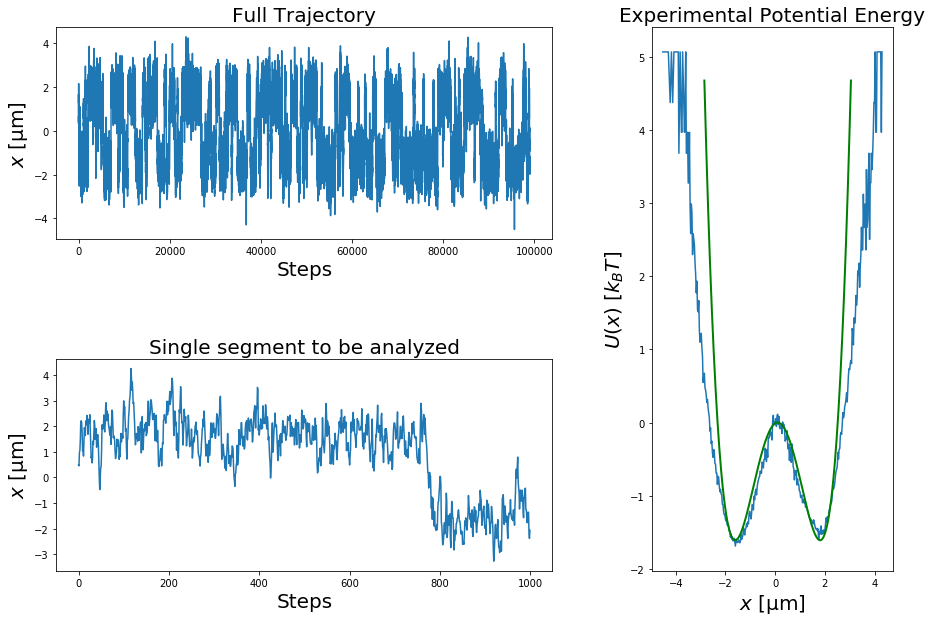

In [2]:
### Import the data 
data_name = 'Data_Example2b'
x = sci.loadmat(data_name)['x']
x = x[1];

### Visualize the trajectory
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(10,10)
plt.subplot(gs[0:4,0:6])
plt.ylabel('$x$ [\u03BCm]',fontsize=20)                     
plt.xlabel('Steps',fontsize=20)
plt.title('Full Trajectory',fontsize=20)
plt.plot(x)

### Visualize a single input for analysis
plt.subplot(gs[6:10,0:6])
plt.ylabel('$x$ [\u03BCm]',fontsize=20)
plt.xlabel('Steps',fontsize=20)
plt.title('Single segment to be analyzed',fontsize=20)
plt.plot(x[23000:28000:5])

### Visualize the measured truths 
l = (np.arange(400) - 200) * 0.025
h = np.histogram(x, bins = l)[0]
U = -np.log(h[h>0]) + np.log(h[round(h.size/2)]) 
plt.subplot(gs[:,7:10])
plt.xlabel('$x$ [\u03BCm]',fontsize=20)
plt.ylabel('$U(x)$ [$k_BT$]',fontsize=20)
plt.title('Experimental Potential Energy',fontsize=20)
plt.plot(l[np.append(h>0,False)],U)
L = 1.71
DU = 1.61
UH = DU*((l/L)**2-1)**2-DU
plt.plot(l[UH<5]+.1,UH[UH<5],c='green',Linewidth = 2)




In [4]:
### Analyze the data
network = load_model('Network_Example_2a.h5')
predictions_L = []
predictions_H = []
oversamp = 5
nmeas = 400
steps = int((x.size-1000*oversamp)/nmeas)
slength = 1000*oversamp
for i in range(nmeas):
    x_crop = x[(i*steps):(i*steps+slength):oversamp]
    predicted_L, predicted_H = DeepCalib.predict(network, x_crop)[0]
    predictions_L.append(predicted_L)
    predictions_H.append(predicted_H)

L0 = 2e-6
H0 = kB*300
rescale_targets = lambda scaled_L, scaled_H: [(1 + scaled_L)*L0, 
                                              np.exp(scaled_H) * H0] # Inverse of targets_scaling    
[predictions_L, predictions_H] = rescale_targets(*np.array([predictions_L, predictions_H]))


Text(0, 0.5, 'Measured Barrier Height [$k_BT$]')

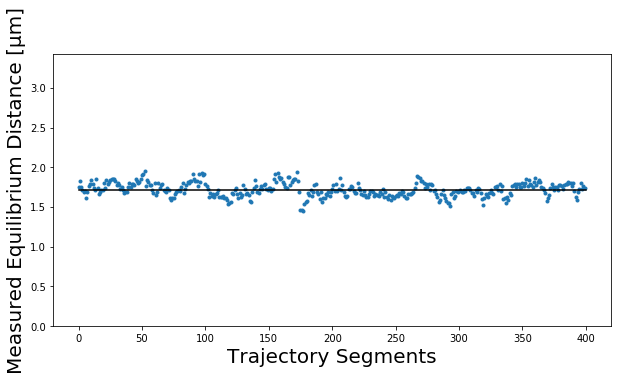

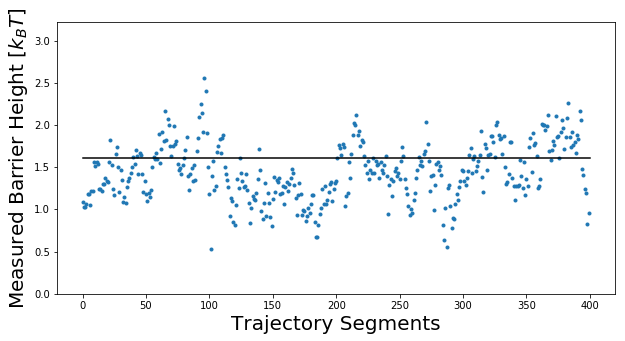

In [5]:
fig = plt.figure(figsize=(10, 5))
plt.plot(predictions_L*1e6,'.')
plt.plot([0, 400], [L, L],color='black')
plt.ylim([0, 2*L])
plt.xlabel('Trajectory Segments',fontsize=20)
plt.ylabel('Measured Equilibrium Distance [\u03BCm]',fontsize=20)

fig = plt.figure(figsize=(10, 5))
plt.plot(predictions_H/kB/300,'.')
plt.plot([0, 400], [DU, DU],color='black')
plt.xlabel('Trajectory Segments',fontsize=20)
plt.ylim([0, 2*DU])
plt.ylabel('Measured Barrier Height [$k_BT$]',fontsize=20)